## Network Attack Example

#### Model of a network attack.  Attack is propagation of an infectious desease.  Graph model is based upon  networkX.  Key to this is graph shape extracted as points for scatter graph.  This is ripe for topological analysis, hopefully.

I've added the ability for nodes to recover from infection. To maintain the network context, this could represent someone realising their machine is infected and updating/installing antivirus to counteract it.

#### Network attack from http://cody.bunta.in/assets/classes/2018_spring_umd_enpm809g/Class10/DiffusionExamples.html

In [1]:
%matplotlib inline

In [2]:
#Imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from celluloid import Camera

from JSAnimation.IPython_display import display_animation, anim_to_html

from scipy import signal
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import scipy.stats as stats

import math

from itertools import product

from sklearn import datasets
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal as mvn

from ripser import Rips

import random as rd

In [62]:
#Class for plotting evolving infection and its persistent homology at each step.
class infectionGrapher():
    
    def __init__(self,graph): #Initialization parameters
        self.g = graph
        self.n = len(self.g.nodes())
        self.pos = nx.get_node_attributes(self.g, "pos")
        self.infected_map = {x:False for x in self.g.nodes}
        self.recovered_map = {x:False for x in self.g.nodes}
        self.min_dur_map = {x:True for x in self.g.nodes}
        self.graphPlots = []
        self.myInfecData = []
        self.myRecovData = []
        self.data_healthy = []
        self.data_infected = []
        self.data_recovered = []
        self.data_uninfected = []
        self.dgms = []

    def reset(self): #In case you want to clear the state without resetting the graph
        self.infected_map = {x:False for x in self.g.nodes}
        self.recovered_map = {x:False for x in self.g.nodes}
        self.min_dur_map = {x:True for x in self.g.nodes}
        self.ims = []
        self.myInfecData = []
        self.myRecovData = []        
        self.data_healthy = []
        self.data_infected = []
        self.data_recovered = []
        self.data_uninfected = []
        self.dgms = []
        
    def initialInfection(self,case_zero): #Starting condition - to-do: extend to multiple case_zeros 
        for i in case_zero:
            self.infected_map[i] = True
            self.min_dur_map[i] = False
        
    def infectionStep(self,trans_p,rec_p,rec_trans_p,vacc_time,step_number): #One step of the infection loop
        # For each infected node, find and infect uninfected neighbors
        for ill_node in [n for n, i in self.infected_map.items() if i]:
            for neighbor in self.g.neighbors(ill_node):

                # probabilistic traaccessing (<matplotlib.collections.PathCollectionnsmission
                if (self.recovered_map[neighbor] == False and self.infected_map[neighbor] == False):
                    if ( np.random.random() < trans_p ):
                        self.infected_map[neighbor] = True
                        self.recovered_map[neighbor] = False
                        self.min_dur_map[neighbor] = False #This ensures they don't recover immediately in the next loop
                if (self.recovered_map[neighbor] == True): #For recovery immunity assumptions
                    if ( np.random.random() < rec_trans_p ):
                        self.infected_map[neighbor] = True
                        self.recovered_map[neighbor] = False
                        self.min_dur_map[neighbor] = False

        # For each previously infected node, see if it recovers
        for ill_node in [n for n, i in self.infected_map.items() if i]:
            if ( np.random.random() < rec_p  and self.min_dur_map[ill_node] == True):
                self.infected_map[ill_node] = False
                self.recovered_map[ill_node] = True

        # Update infected colors
        if (vacc_time == None): #If we're not using the vaccination feature
            self.colors = [1.0 if self.infected_map[x] else 0.4 if self.recovered_map[x] else 0.0 for x in self.g.nodes]
        else:
            if (step_number < vacc_time): #if vaccine hasn't been introduced yet
                self.colors = [1.0 if self.infected_map[x] else 0.4 if self.recovered_map[x] else 0.0 for x in self.g.nodes]
            if (step_number >= vacc_time): #post vaccination
                self.colors = [1.0 if self.infected_map[x] else 0.75 if self.recovered_map[x] else 0.0 for x in self.g.nodes]
                
        #Set all the ill nodes as being capable of recovery
        for ill_node in [n for n, i in self.infected_map.items() if i]:
            self.min_dur_map[ill_node] = True

    def initialGraph(self): #Draw the dirst graph
        self.graph_fig = plt.figure()
        self.graph_fig.set_figheight(10)
        self.graph_fig.set_figwidth(15)
        self.ax = self.graph_fig.gca()
        nx.draw_networkx_edges(self.g, self.pos, ax=self.ax)
        
        self.cmap = plt.get_cmap("rainbow")
        self.colors = [1.0 if self.infected_map[x] else 0.0 for x in self.g.nodes]
        
        self.graphPlots = [(nx.draw_networkx_nodes(self.g, self.pos, node_color=self.colors, cmap=self.cmap, ax=self.ax, vmin=0.0, vmax=1.0),)]
    
    def updateGraph(self): #Draw a graph at the current state
        self.graphPlots.append(
        (nx.draw_networkx_nodes(self.g, self.pos, node_color=self.colors, cmap=self.cmap, ax=self.ax, vmin=0.0, vmax=1.0),)
        )
        
    def infector(self,niters,case_zero,trans_p,rec_p=0.0,rec_trans_p=0.0,vacc_time=None,early_stopping=True,static_time=5, 
                 draw_graph = True,plot_homology = True, print_Fin = True): #Runs the infection loop
        
        #Starting case
        self.initialInfection(case_zero)
        
        #If we're drawing graphs
        if (draw_graph == True): 
            self.initialGraph()
            
        #If we're plotting homologies
        if (plot_homology == True):
                self.data_healthy.append(np.transpose(self.healthyCounter()))
                self.data_infected.append(np.transpose(self.infectedCounter()))
                self.data_recovered.append(np.transpose(self.recoveredCounter()))
                self.data_uninfected.append(np.transpose(self.uninfectedCounter()))
        
        #Count current infections
        last_infected_count = sum([1 for n, i in self.infected_map.items() if i])
        infected_counts = [last_infected_count]

        #Count current recoveries
        last_recovered_count = sum([1 for n, i in self.recovered_map.items() if i])
        recovered_counts = [last_recovered_count]
        
        for i in range(niters): #Iterate over the number of steps
            if (vacc_time != None): #If we're in a post-vaccination development world
                if (i >= vacc_time):
                    rec_trans_p = 0.0 #Recovered nodes can't be reinfected
            
            self.infectionStep(trans_p,rec_p,rec_trans_p,vacc_time,i) #Run a step of the infection
            
            #Add current graph if we're drawing
            if (draw_graph == True):
                self.updateGraph()
                
            #Add current node data if we're drawing homologies
            if (plot_homology == True):
                self.data_healthy.append(np.transpose(self.healthyCounter()))
                self.data_infected.append(np.transpose(self.infectedCounter()))
                self.data_recovered.append(np.transpose(self.recoveredCounter()))
                self.data_uninfected.append(np.transpose(self.uninfectedCounter()))
             
            #Update infected and recovered counts
            infected_count = sum([1 for n, i in self.infected_map.items() if i])
            recovered_count = sum([1 for n, i in self.recovered_map.items() if i])
    
            #Update list of total infections and recoveries
            self.myInfecData.append(infected_count)
            self.myRecovData.append(recovered_count)
    
            #If we've reached total infection, stop
            if ( infected_count == len(self.g.nodes) ):
                if print_Fin == True:
                    print("Total Infection After:", i+1)
                break
        
            #If there are no more infected cases, stop
            if ( infected_count == 0 ):
                if print_Fin == True:
                    print("Total recovery after:", i+1)
                break
                
            #For handling isolated cluster cases that will never be infected 
            if (early_stopping == True) and (i >= niters):
                if ((np.array_equal(self.data_healthy[i],self.data_healthy[i-static_time]) == True) and (np.array_equal(self.data_infected[i],self.data_infected[i-static_time]) == True)):
                    if print_Fin == True:
                        print("No further changes after:", i+1)
                    break
   
            #Update infected and recovery counts
            last_infected_count = infected_count 
            infected_counts.append(last_infected_count)
            last_recovered_count = recovered_count 
            recovered_counts.append(last_recovered_count)
            
        self.fin_number = i+1 #Note when we stop
    
    ##################
    #The counter functions give the coordintes of the points with each status at each time step
    def healthyCounter(self):
        healthy0 = []
        healthy1 = []
        
        for i in range(0,self.n):
            if self.recovered_map[i] == True:
                healthy0.append(pos[i][0])
                healthy1.append(pos[i][1])
            if (self.infected_map[i] == False and self.recovered_map[i] == False): #Never infected in the first place
                healthy0.append(pos[i][0]) 
                healthy1.append(pos[i][1])
        
        return [healthy0, healthy1]
        
    def infectedCounter(self):
        infec0 = []
        infec1 = []
        
        for i in range(0,self.n):
            if self.infected_map[i] == True:
                infec0.append(pos[i][0])
                infec1.append(pos[i][1])
        
        return [infec0, infec1]
        
    def recoveredCounter(self):
        recov0 = []
        recov1 = []
        
        for i in range(0,self.n):
            if self.recovered_map[i] == True:
                recov0.append(pos[i][0])
                recov1.append(pos[i][1])        
                
        return [recov0, recov1]
            
    def uninfectedCounter(self):
        uninfected0 = []
        uninfected1 = []
        
        for i in range(0,self.n):        
            if (self.infected_map[i] == False and self.recovered_map[i] == False): #Never infected in the first place
                uninfected0.append(pos[i][0])
                uninfected1.append(pos[i][1])
                
        return [uninfected0, uninfected1]
    
    ##################

    #Animate the evolution of infection
    def graphAnimator(self):
        self.graph_ani = animation.ArtistAnimation(self.graph_fig, self.graphPlots, interval=150, repeat_delay=3000,
                                   blit=True)
        #display_animation(self.graph_ani) #For some reason it won't do anything if you tell it to just show it.
                                    #Put this line outside the class function (referring to the class's.im_ani property)
        
        
    #Plot the number of infections over time
    def infectionPlotter(self):
        plt.plot(np.maximum(np.diff(self.myInfecData),0))
        plt.title('Rate of infection')
        plt.xlabel('Epoch')
        plt.ylabel('Number of new infections')
        plt.show()
        
    #Plot the number of recoveries over time
    def recoveryPlotter(self):
        plt.plot(np.maximum(np.diff(self.myRecovData),0))
        plt.title('Rate of Recovery')
        plt.xlabel('Epoch')
        plt.ylabel('Number of new recoveries')
        plt.show()
        
    #Chooses the data type based on what you want plotted for homology plotting
    def dataSelector(self,num_type): #num_type: 0 = Healthy, 1 = Infected, 2 = Recovered, 3 = Uninfected
        data = []
        
        if num_type == 0:
            data = self.data_healthy
            label = 'healthy'
        if num_type == 1:
            data = self.data_infected
            label = 'infected'
        if num_type == 2:
            data = self.data_recovered
            label = 'recovered'
        if num_type == 3:
            data = self.data_uninfected
            label = 'uninfected'
            
        return data, label
        
    #Plots a single case of the persistence diagram (Doesn't store values)
    def homologyPlot(self,num_type,step):
        data = []
        dgms_temp = []
        self.rips = Rips(verbose=False)
        
        data = self.dataSelector(num_type)
        
        if (data[0][step].size != 0):
            dgms_temp = self.rips.fit_transform(data[0][step]) 
            self.rips.plot(dgms_temp, legend=True, show=False)
        else:
            print('No data found at this step.')
            
    #Generates the persistence diagrams over all steps
    def homologyGenerator(self,num_type,maxdim=1):
        data = []
        self.dgms = [None] * self.fin_number
        self.rips = Rips(verbose=False,maxdim=maxdim)
        
        data = self.dataSelector(num_type)

        for i in range(self.fin_number):
            self.dgms[i] = self.rips.fit_transform(data[0][i]) 
        
    #Animates the persistence diagram over all iterations
    def homologyAnimator(self,num_type,file_name=None,plot_limits = [-0.05,0.5,-0.05,0.5],maxdim=1): 
        data = []
        
        self.homologyGenerator(num_type,maxdim)
        
        data = self.dataSelector(num_type)
        colors = {0:'purple',1:'red',2:'green',3:'blue'}
        
        if (file_name == None):
            file_name = "{}_persistent_homology.gif".format(data[1])
        
        pers_fig = plt.figure()
        camera = Camera(pers_fig)
        
        for i in range(self.fin_number):
            if (data[0][i].size == 0):
                camera.snap()
            else:
                plt.subplot(121)
                plt.scatter(data[0][i][:,0],data[0][i][:,1],s=4,c=colors[num_type])
                
                plt.subplot(122)
                self.rips.plot(self.dgms[i], xy_range=plot_limits, legend=False, show=False)
                camera.snap()
            
        animation = camera.animate()
        animation.save(file_name, writer = 'imagemagick')
        

#### Some Graph generators from Networkx

In [63]:
n = 256
# g = nx.erdos_renyi_graph(n, 1.)
# g = nx.erdos_renyi_graph(n, 10/(n-1))
# g = nx.watts_strogatz_graph(n, 4, 0.001)
# g = nx.barabasi_albert_graph(n, 2)
# g = nx.powerlaw_cluster_graph(n, 2, 0.01)
# g = nx.relaxed_caveman_gr$aph(16, 16, 0.12)
# g = nx.read_graphml("risk.graphml").to_undirected()
# g = nx.read_graphml("USAir97.graphml").to_undirected()

g = nx.random_geometric_graph(n, 0.125)
# position is stored as node attribute data for random_geometric_graph
pos = nx.get_node_attributes(g, "pos")

#print("Nodes:", len(g.nodes))
#pos = nx.fruchterman_reingold_layout(g, k=0.1)

# The KK layout algorithm takes a minute
# pos = nx.kamada_kawai_layout(g)


#### Pos only seems to be given for random_geometric_graph - Way of getting this attribute for other graphs?

#### Starting example of generating a graph and putting an infection through it

In [64]:
g = nx.scale_free_graph(n)
g = g.to_undirected()
g = nx.Graph(g)

In [299]:
graph = infectionGrapher(g)

graph.infector(niters=50,case_zero=[94],trans_p=0.25,rec_p=0.0,rec_trans_p=0.25,draw_graph=False)
#graph.graphAnimator()
#display_animation(graph.graph_ani)

Total Infection After: 29


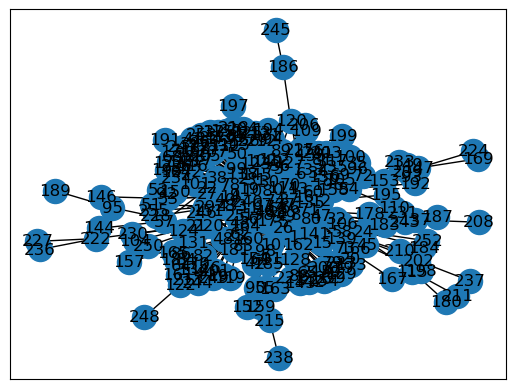

In [66]:
nx.draw_networkx(g)

#### Animate the evolution of the infection in terms of persistency diagrams

C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input

C:\Users\Jack\anaconda3\lib\site-packages\ipykernel_launcher.py:310: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Jack\anaconda3\lib\site-packages\ipykernel_launcher.py:307: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Jack\anaconda3\lib\site-packages\ipykernel_launcher.py:310: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

C:\Users\Jack\anaconda3\lib\site-packages\ipykernel_launcher.py:310: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Jack\anaconda3\lib\site-packages\ipykernel_launcher.py:307: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Jack\anaconda3\lib\site-packages\ipykernel_launcher.py:310: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


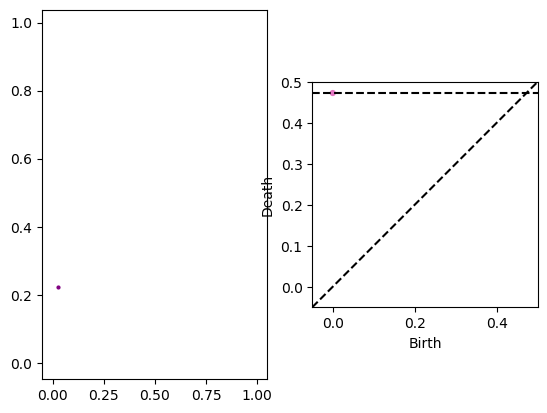

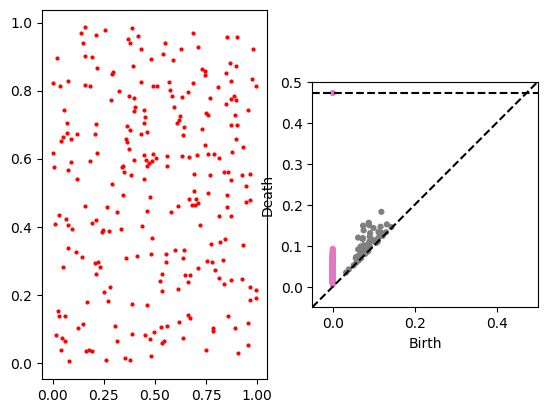

In [69]:
graph.homologyAnimator(0,maxdim=1)
graph.homologyAnimator(1,maxdim=1)

#### Animate the evolution of barcodes as a histogram for a single infection case 

C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"
MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


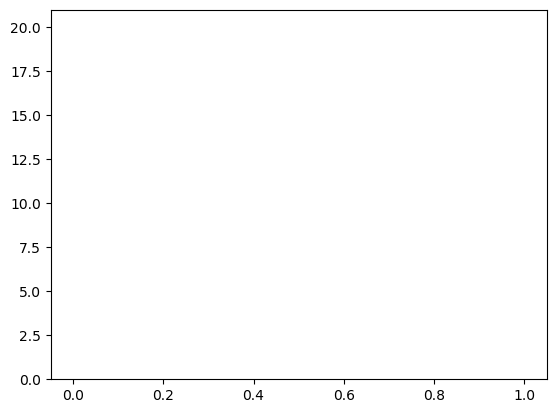

In [9]:
graph.homologyGenerator(1)

file_name = 'homology_transition_h1_histogram.gif'
        
pers_fig = plt.figure()
camera = Camera(pers_fig)
        
for i in range(graph.fin_number):
    plt.hist(graph.dgms[i][1][:,1]-graph.dgms[i][1][:,0])
    camera.snap()
            
animation = camera.animate()
animation.save(file_name, writer = 'imagemagick')

#### Animate the evolution of barcodes over a large sample of graphs and starting infection points

C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mea

C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mea

C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more colu

C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is o

C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more colu

C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is o

C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mea

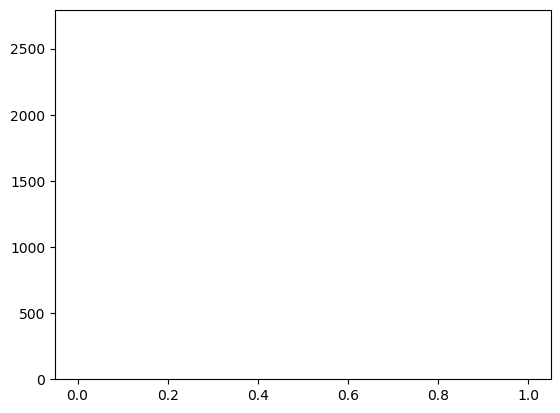

In [289]:
n_starts= 10
n_graphs = 10
n_steps = 10
h0_barcodes = [None] * n_steps
h1_barcodes = [None] * n_steps
num_type = 1

counter = 0

for _ in range(n_graphs):
    g = nx.scale_free_graph(n)
    g = g.to_undirected()
    while nx.is_connected(g) == False:
        g = nx.scale_free_graph(n)
    g = g.to_undirected()
    g = nx.Graph(g) 

    for i in range(n_starts):
        case_zero = [np.random.randint(0,n)]
        graph = infectionGrapher(g)
        graph.infector(niters=50,case_zero=case_zero,trans_p=0.5,rec_p=0.0,rec_trans_p=0.25,early_stopping=False,
                       draw_graph=False,print_Fin=False)
        graph.homologyGenerator(num_type)

        if (n_steps <= graph.fin_number):
            for j in range(0,n_steps): 
                k = max(np.int(graph.fin_number*((j+1)*(1/n_steps)))-1,0)
                h0 = graph.dgms[k][0]
                h1 = graph.dgms[k][1]

                if (i == 0) and (counter == 0):
                    h0_barcodes[j] = h0
                    h1_barcodes[j] = h1
                else:
                    h0_barcodes[j] = np.vstack((h0_barcodes[j],h0))
                    h1_barcodes[j] = np.vstack((h1_barcodes[j],h1))

            counter = counter + 1
            
            
file_name = 'homology_transition_h1_histogram.gif'
        
pers_fig = plt.figure()
camera = Camera(pers_fig)
        
for i in range(n_steps):
    plt.hist(h1_barcodes[i][:,1]-h1_barcodes[i][:,0])
    camera.snap()
            
animation = camera.animate()
animation.save(file_name, writer = 'imagemagick')

#### Plot a scatter graph of the infection time as a function of betweenness centrality of the case zero node

Text(0, 0.5, 'Infection time')

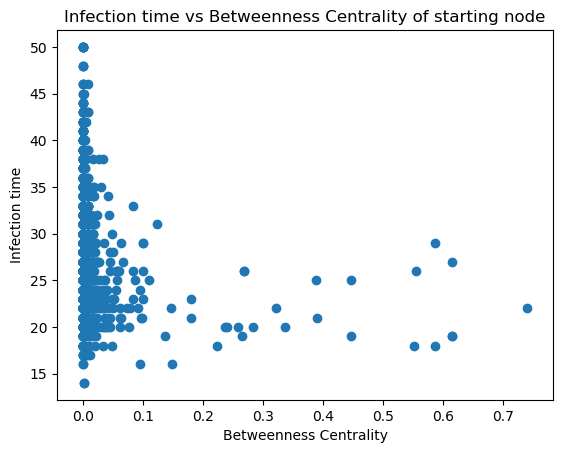

In [291]:
n_graphs= 25
n_samples = np.int(n/3)
betweenness_centrality_list = []
infection_time_list_betweenness = []

for _ in range(n_graphs):
    g = nx.scale_free_graph(n)
    g = g.to_undirected()
    while nx.is_connected(g) == False:
        g = nx.scale_free_graph(n)
    g = g.to_undirected()
    g = nx.Graph(g) 
    betweeness_list = nx.betweenness_centrality(g)
    
    for _ in range(n_samples):
        case_zero = [np.random.randint(0,n)]
        betweenness_centrality_list.append(betweeness_list[case_zero[0]])
        graph = infectionGrapher(g)
        graph.infector(niters=50,case_zero=case_zero,trans_p=0.25,rec_p=0.0,rec_trans_p=0.25,static_time=10,
                       draw_graph=False,print_Fin=False)
        infection_time_list_betweenness.append(graph.fin_number)
        
plt.scatter(betweenness_centrality_list,infection_time_list_betweenness)
plt.title("Infection time vs Betweenness Centrality of starting node")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Infection time")
#plt.scatter(infection_time_list_betweenness,betweenness_centrality_list)

The results here suggest that case_zeros with a higher betweenness centrality infect the rest of the graph at a faster rate, though there's a high amount of variance.

#### Plot a scatter graph of the infection time as a function of the degree of the case zero node

Text(0, 0.5, 'Infection time')

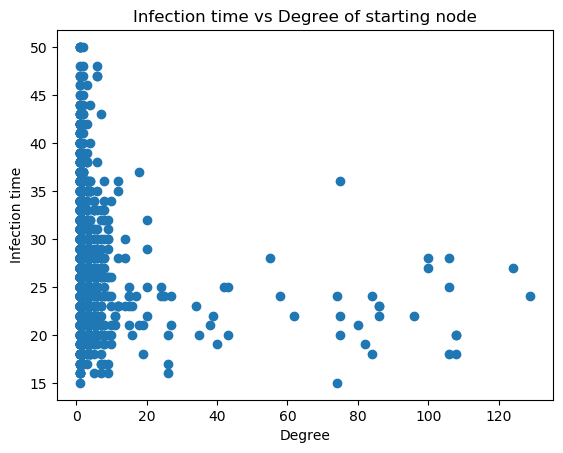

In [292]:
n_graphs= 25
n_samples = np.int(n/3)
degree_list = []
infection_time_list_degree = []

for _ in range(n_graphs):
    g = nx.scale_free_graph(n)
    g = g.to_undirected()
    while nx.is_connected(g) == False:
        g = nx.scale_free_graph(n)
    g = g.to_undirected()
    g = nx.Graph(g) 
    
    for _ in range(n_samples):
        case_zero = [np.random.randint(0,n)]
        degree_list.append(g.degree(case_zero[0]))
        graph = infectionGrapher(g)
        graph.infector(niters=50,case_zero=case_zero,trans_p=0.25,rec_p=0.0,rec_trans_p=0.25,static_time=10,
                       draw_graph=False,print_Fin=False)
        infection_time_list_degree.append(graph.fin_number)
        
plt.scatter(degree_list,infection_time_list_degree)
plt.title("Infection time vs Degree of starting node")
plt.xlabel("Degree")
plt.ylabel("Infection time")
#plt.scatter(infection_time_list_degree,degree_list)

Seeing how case_zero degree (number of edges) relates to the infection time. It looks like there's a stronger relationship with higher degree case zeros resulting in faster infection times, which is intuitive.

#### Plot a cumulative count of the infection coverage of the network over time.

Text(0, 0.5, 'Proportion Infected')

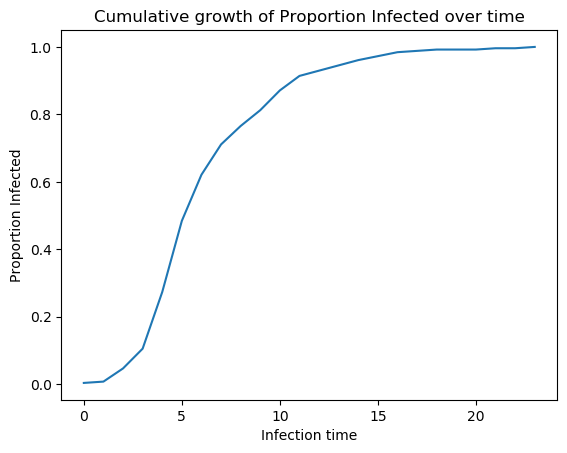

In [293]:
plt.plot(np.divide(graph.myInfecData,n))
plt.title("Cumulative growth of Proportion Infected over time")
plt.xlabel("Infection time")
plt.ylabel("Proportion Infected")

#### Playing around with fitting distributions to the h1 barcodes

C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
C:\Users\Jack\anaconda3\lib\site-packages\ripser\ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The inp

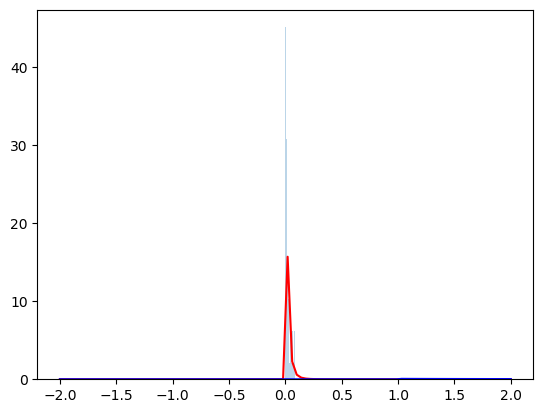

In [307]:
graph.homologyGenerator(1)

data= graph.dgms[graph.fin_number-1][1][:,1]-graph.dgms[graph.fin_number-1][1][:,0]

param =  stats.pareto.fit(data)

# now, param[0] and param[1] are the mean and 
# the standard deviation of the fitted distribution
x = np.linspace(-2,2,100)
# fitted distribution
pdf_fitted = stats.pareto.pdf(x,param[0],param[1],param[2])
# original distribution
pdf = stats.pareto.pdf(x,param[2])

plt.plot(x,pdf_fitted,'r-',x,pdf,'b-')
plt.hist(data,normed=1,alpha=.3)
plt.show()

0